# Particle Filters

In [1]:
from math import *
import random
import matplotlib.pyplot as plt
%matplotlib inline

## Robot Class

In [2]:
landmarks  = [[20.0, 20.0], [80.0, 80.0], [20.0, 80.0], [80.0, 20.0]]
world_size = 100.0


class robot:
    def __init__(self):
        self.x = random.random() * world_size
        self.y = random.random() * world_size
        self.orientation = random.random() * 2.0 * pi
        self.forward_noise = 0.0;
        self.turn_noise    = 0.0;
        self.sense_noise   = 0.0;
    
    def set(self, new_x, new_y, new_orientation):
        if new_x < 0 or new_x >= world_size:
            raise ValueError('X coordinate out of bound')
        if new_y < 0 or new_y >= world_size:
            raise ValueError('Y coordinate out of bound')
        if new_orientation < 0 or new_orientation >= 2 * pi:
            raise ValueError('Orientation must be in [0..2pi]')
        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation)
    
    
    def set_noise(self, new_f_noise, new_t_noise, new_s_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.forward_noise = float(new_f_noise);
        self.turn_noise    = float(new_t_noise);
        self.sense_noise   = float(new_s_noise);
    
    
    def sense(self):
        Z = []
        for i in range(len(landmarks)):
            dist = sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            dist += random.gauss(0.0, self.sense_noise)
            Z.append(dist)
        return Z
    
    
    def move(self, turn, forward):
        if forward < 0:
            raise ValueError('Robot cant move backwards')
        
        # turn, and add randomness to the turning command
        orientation = self.orientation + float(turn) + random.gauss(0.0, self.turn_noise)
        orientation %= 2 * pi
        
        # move, and add randomness to the motion command
        dist = float(forward) + random.gauss(0.0, self.forward_noise)
        x = self.x + (cos(orientation) * dist)
        y = self.y + (sin(orientation) * dist)
        x %= world_size    # cyclic truncate
        y %= world_size
        
        # set particle
        res = robot()
        res.set(x, y, orientation)
        res.set_noise(self.forward_noise, self.turn_noise, self.sense_noise)
        return res
    
    def Gaussian(self, mu, sigma, x):    
        # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
        return exp(- ((mu - x) ** 2) / (sigma ** 2) / 2.0) / sqrt(2.0 * pi * (sigma ** 2))
    
    def measurement_prob(self, measurement):
        # calculates how likely a measurement should be
        prob = 1.0;
        for i in range(len(landmarks)):
            dist = sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            prob *= self.Gaussian(dist, self.sense_noise, measurement[i])
        return prob
    
    def __repr__(self):
        return '[x=%.6s y=%.6s orient=%.6s]' % (str(self.x), str(self.y), str(self.orientation))

In [3]:
myrobot = robot()
myrobot.set(30,50,pi/2)
myrobot = myrobot.move(-pi/2, 15)
print(myrobot.sense())
myrobot = myrobot.move(-pi/2, 10)
print(myrobot.sense())

[39.05124837953327, 46.09772228646444, 39.05124837953327, 46.09772228646444]
[32.01562118716424, 53.150729063673246, 47.16990566028302, 40.311288741492746]


## Particle Filter

In [4]:
myrobot = robot()
myrobot = myrobot.move(0.1, 5.0)
Z = myrobot.sense()

In [5]:
# make a 1000 particles
N = 1000
p = []
for i in range(N):
    x = robot()
    x.set_noise(0.05, 0.05, 5.0)
    p.append(x)

In [6]:
# simulate motion
for i in range(len(p)):
    p[i] = p[i].move(0.1, 5)

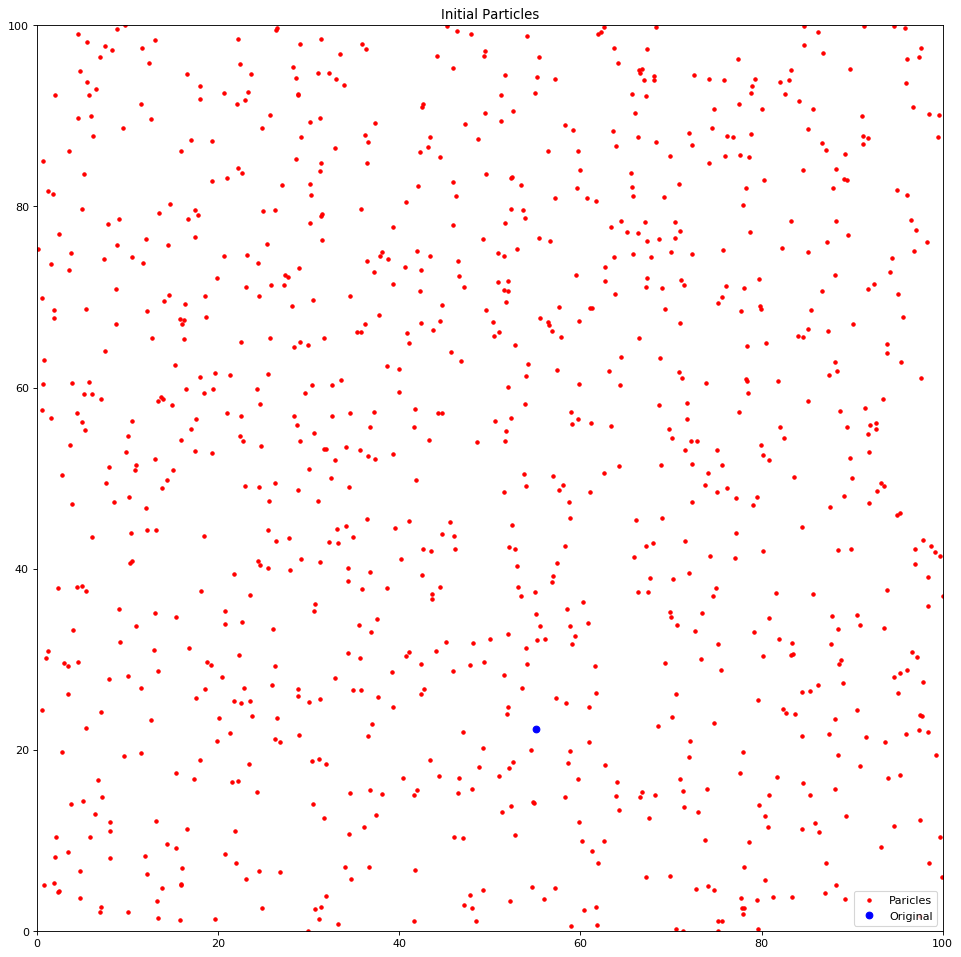

In [7]:
fig = plt.figure(figsize=(15, 15), dpi= 80)
ax = fig.add_subplot(111)
ax.set_aspect(aspect=1.0)
plt.ylim(0,100)
plt.xlim(0,100)
plt.plot([i.x for i in p], [i.y for i in p], 'r.')
plt.plot(myrobot.x, myrobot.y, 'b.', markersize=12)
plt.title('Initial Particles')
plt.legend(['Paricles', 'Original'])

In [8]:
# calculate importance weights
w = [i.measurement_prob(Z) for i in p]

In [9]:
# resample
p_resample = []
w_max = max(w)
index = int(round(random.uniform(0, N-1)))
beta = 0
for i in range(N):
    beta += random.uniform(0, 2*w_max)
    while w[index] < beta:
        beta -= w[index]
        index = (index + 1) % N
    p_resample.append(p[index])

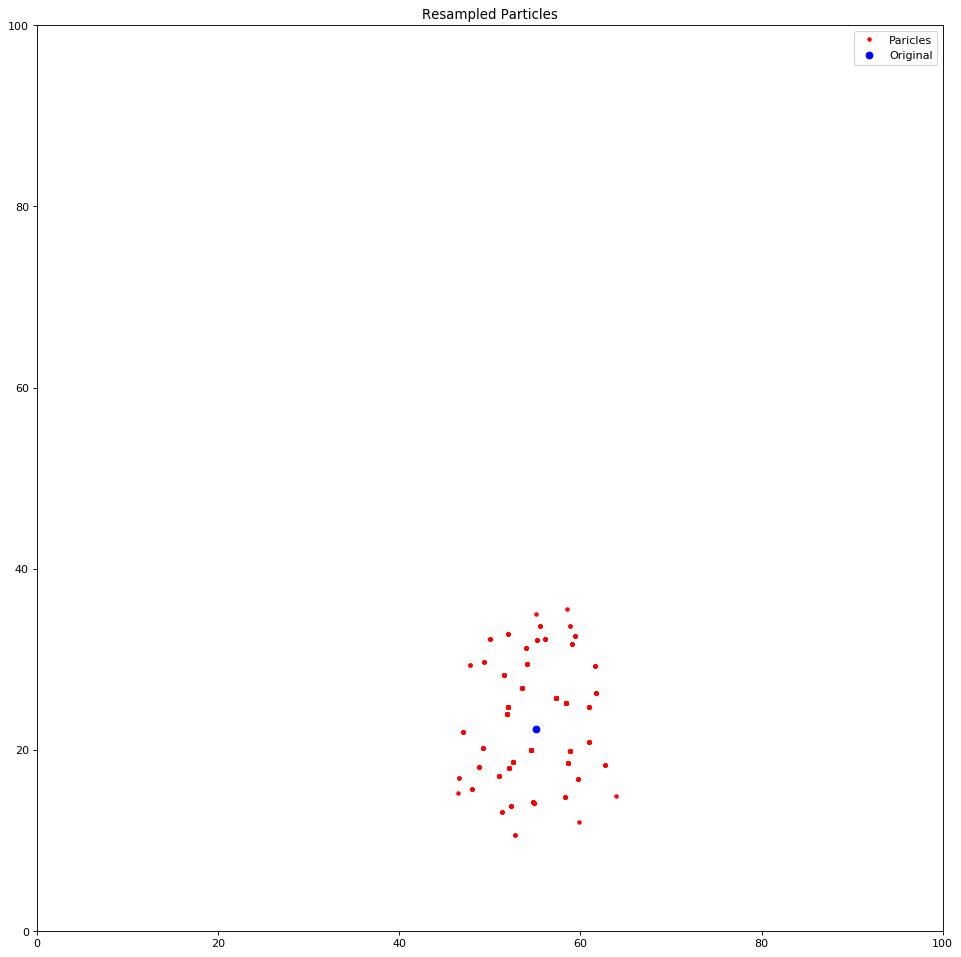

In [10]:
fig = plt.figure(figsize=(15, 15), dpi= 80)
ax = fig.add_subplot(111)
ax.set_aspect(aspect=1.0)
plt.ylim(0,100)
plt.xlim(0,100)
plt.plot([i.x for i in p_resample], [i.y for i in p_resample], 'r.')
plt.plot(myrobot.x, myrobot.y, 'b.', markersize=12)
plt.title('Resampled Particles')
plt.legend(['Paricles', 'Original'])

In [11]:
# get mean of particles
mean_x = 0
mean_y = 0
for x in p_resample:
    mean_x += x.x
    mean_y += x.y
mean_x /= 1000
mean_y /= 1000
print(myrobot.x, mean_x)
print(myrobot.y, mean_y)

55.110148909423025 55.087164789058555
22.315771527775105 22.435247803295333


In [12]:
# error in system
def eval(r, p):
    sum = 0.0;
    for i in range(len(p)): # calculate mean error
        dx = (p[i].x - r.x + (world_size/2.0)) % world_size - (world_size/2.0)
        dy = (p[i].y - r.y + (world_size/2.0)) % world_size - (world_size/2.0)
        err = sqrt(dx * dx + dy * dy)
        sum += err
    return sum / float(len(p))

In [13]:
# simulate for T
myrobot = robot()
myrobot = myrobot.move(0.1, 5.0)
Z = myrobot.sense()
N = 1000
T = 20

p = []
for i in range(N):
    r = robot()
    r.set_noise(0.05, 0.05, 5.0)
    p.append(r)

evals = []
evals.append(eval(myrobot, p))
for t in range(T):
    # simulate motion of robot
    myrobot = myrobot.move(0.1, 5.0)
    Z = myrobot.sense()

    # simulate motion of particles
    for i in range(len(p)):
        p[i] = p[i].move(0.1, 5)

    # calculate weights
    w = [i.measurement_prob(Z) for i in p]

    # resample
    p_resample = []
    w_max = max(w)
    index = int(round(random.uniform(0, N-1)))
    beta = 0
    for i in range(N):
        beta += random.uniform(0, 2*w_max)
        while w[index] < beta:
            beta -= w[index]
            index = (index + 1) % N
        p_resample.append(p[index])
    p = p_resample
    evals.append(eval(myrobot, p))

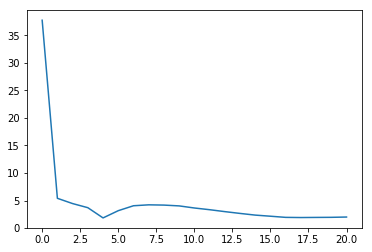

In [14]:
plt.plot(evals)

In [15]:
evals[-1]

2.0058213659943425